## Car Damage Severity Classification
### Autumn Mizer, Peter Kwaterski,

This notebook implements a deep learning model using InceptionV3 which is pretrained on ImageNet to classify car damage severity into minor, moderate, and severe. The dataset is made by Prajwal Bhamere and comes from https://www.kaggle.com/datasets/prajwalbhamere/car-damage-severity-dataset/data.

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

The code segment below takes care of data processing and augmentation. The InceptionV3 model is trained for 299x299 RGB images, so the datasets images need to be scaled to work as intended with the base model. These augmentation settings were also found to be helpful for training accuracy for this dataset, and is also done to prevent overfitting. Only rescaling has been done to the validation data.

In [63]:
img_size = (299,299) # inceptionv3 requires 299x299 rgb
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

train = datagen.flow_from_directory(
    "../dataset/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

datagen = ImageDataGenerator(rescale=1./255)

val = datagen.flow_from_directory(
    "../dataset/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


The code segment below contains the base model implementation of InceptionV3. It uses the pretrained ImageNet weights.

More information can be found here for the base model
https://keras.io/api/applications/inceptionv3/

In [39]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

#freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

In [40]:
#classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.3)(x)
preds = Dense(3, activation='softmax')(x)

#model to new head
model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=5e-4), #head training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
history_head = model.fit(
    train,
    validation_data = val,
    epochs=10
)

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4244 - loss: 1.1752 - val_accuracy: 0.4879 - val_loss: 0.9311
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5351 - loss: 0.9453 - val_accuracy: 0.6129 - val_loss: 0.8246
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5792 - loss: 0.8634 - val_accuracy: 0.6653 - val_loss: 0.7320
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5857 - loss: 0.8621 - val_accuracy: 0.6855 - val_loss: 0.7065
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5900 - loss: 0.8379 - val_accuracy: 0.7379 - val_loss: 0.6862
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5879 - loss: 0.8291 - val_accuracy: 0.7218 - val_loss: 0.6752
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6211 - loss: 0.7961 - val_accuracy: 0.6895 - val_loss: 0.6746
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6074 - loss: 0.8173 - val_accuracy: 0.7218 - val_loss:

Text(0.5, 1.0, 'Loss')

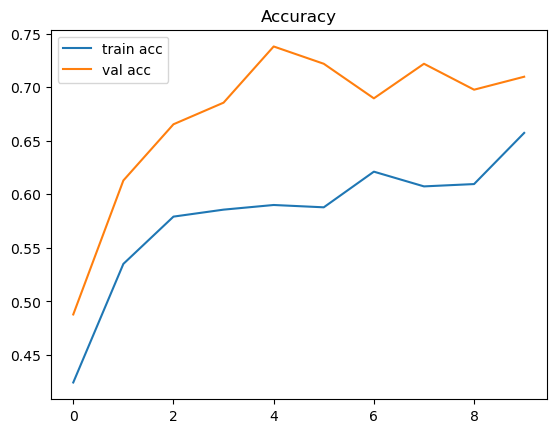

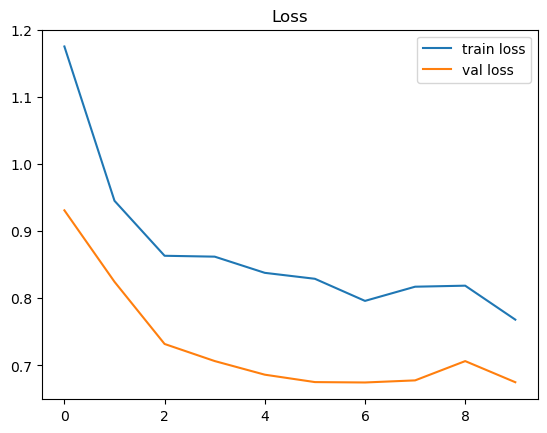

In [43]:
plt.plot(history_head.history['accuracy'], label='train acc')
plt.plot(history_head.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.figure()
plt.plot(history_head.history['loss'], label='train loss')
plt.plot(history_head.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

In [ ]:
num_unfreeze = 100

#unfreeze layers for finetuning
for layer in base_model.layers[-num_unfreeze:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-7), #finetuning pretrained layers
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_tune = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ) #prevent overfitting
    ]
)  

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5625 - loss: 0.9197 - val_accuracy: 0.7581 - val_loss: 0.6138 - learning_rate: 1.0000e-05
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.6197 - loss: 0.7862 - val_accuracy: 0.7500 - val_loss: 0.6025 - learning_rate: 1.0000e-05
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6312 - loss: 0.7646 - val_accuracy: 0.7540 - val_loss: 0.5955 - learning_rate: 1.0000e-05
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6580 - loss: 0.7465 - val_accuracy: 0.7581 - val_loss: 0.5888 - learning_rate: 1.0000e-05
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6898 - loss: 0.7066 - val_accuracy: 0.7500 - val_loss: 0.5812 - learning_rate: 1.0000e-05
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.6999 - loss: 0.6978 - val_accuracy: 0.7419 - val_loss: 0.5696 - learning_rate: 1.0000e-05
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7021 

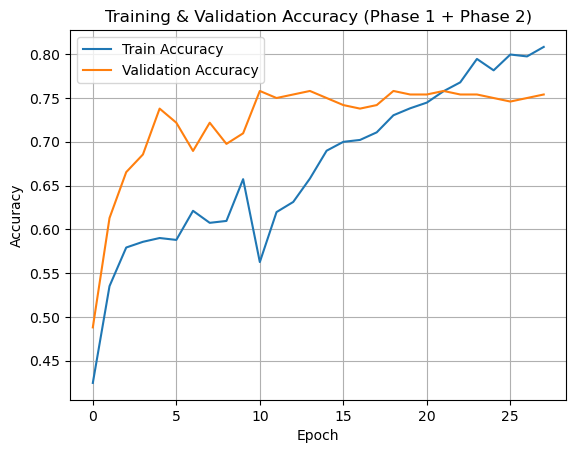

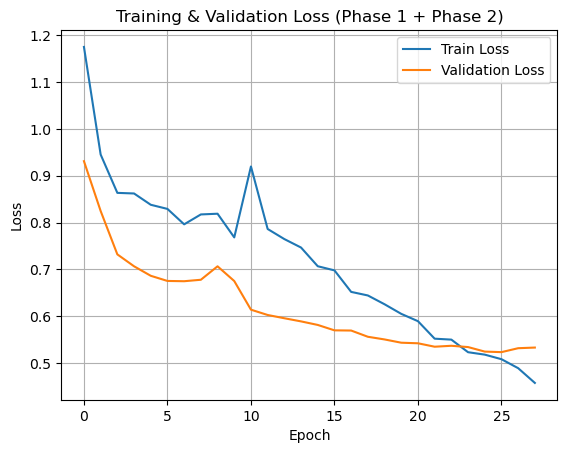

In [45]:
acc = history_head.history['accuracy'] + history_tune.history['accuracy']
val_acc = history_head.history['val_accuracy'] + history_tune.history['val_accuracy']

loss = history_head.history['loss'] + history_tune.history['loss']
val_loss = history_head.history['val_loss'] + history_tune.history['val_loss'] 

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Phase 1 + Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training & Validation Loss (Phase 1 + Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


7/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x309a0ff60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


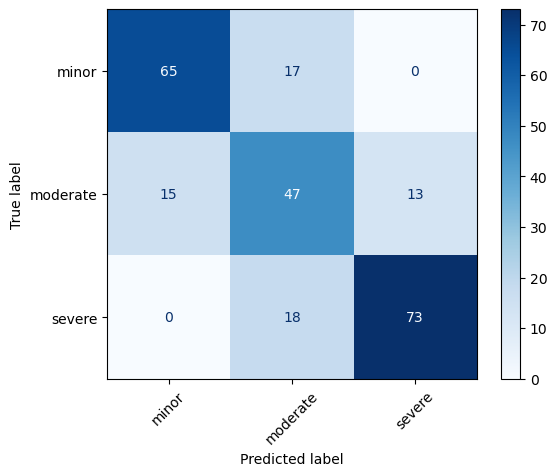

              precision    recall  f1-score   support

       minor       0.81      0.79      0.80        82
    moderate       0.57      0.63      0.60        75
      severe       0.85      0.80      0.82        91

    accuracy                           0.75       248
   macro avg       0.74      0.74      0.74       248
weighted avg       0.75      0.75      0.75       248



In [46]:
y_true = val.classes
y_pred = model.predict(val)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_labels)
labels = list(train.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=labels))

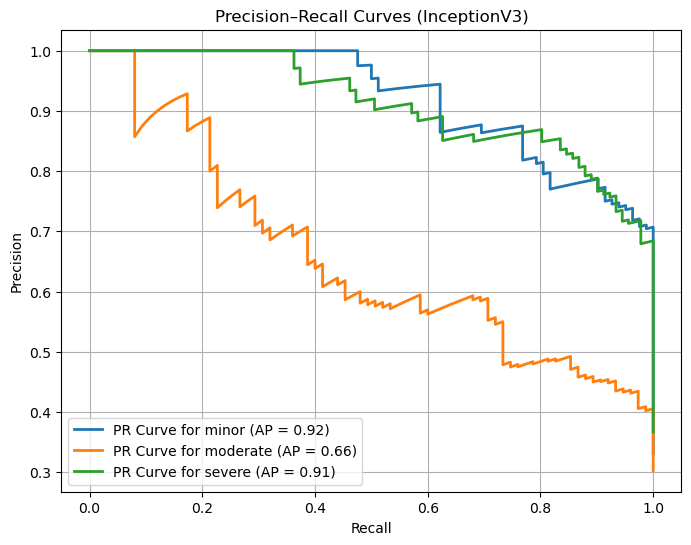

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

precision = {}
recall = {}
avg_precision = {}

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_pred[:, i])

    plt.plot(
        recall[i],
        precision[i],
        lw=2,
        label=f"PR Curve for {labels[i]} (AP = {avg_precision[i]:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (InceptionV3)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


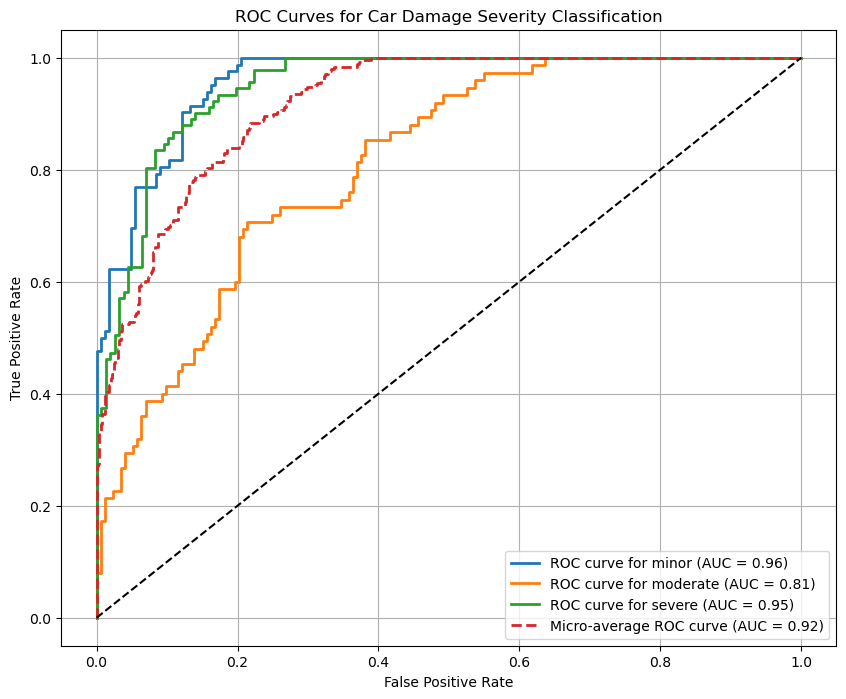

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

labels = list(train.class_indices.keys())
n_classes = len(labels)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label=f"ROC curve for {labels[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


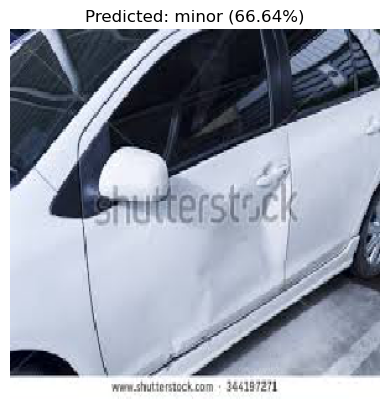

prediction probabilities: [[0.6663915  0.32318828 0.01042026]]


In [65]:
from tensorflow.keras.preprocessing import image

#0020.jpeg minor
#0012.jpeg moderate
#0019.jpeg severe
img_path = "../dataset/val/moderate/0012.jpeg"  

# preprocess image
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # scale
img_array = np.expand_dims(img_array, axis=0)

# predict
pred = model.predict(img_array)
pred_class_idx = np.argmax(pred, axis=1)[0]

# get lbls
labels = list(train.class_indices.keys())
pred_class_label = labels[pred_class_idx]

# show image + predict
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_class_label} ({pred[0][pred_class_idx]*100:.2f}%)")
plt.show()

print("prediction probabilities:", pred)
